# Table of Contents

* [Data Preparation](#1)
* [Customer Segmentation](#2)
     * [Clustering the products using k-means algorithm](#3)
     * [Clustering Analysis](#10)
     * [Clustering Visualization](#11)
     * [Clustering the customers using k-means algorithm](#12)
* [Customer Classification](#25)
* [RFM Analysis](#25)
* [Market Basket Analysis](#25)

# 1. Data Preparation <a id="1"></a>

In [9]:
import pandas as pd
import numpy as np
import datetime 
import itertools

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
import squarify

import nltk
nltk.download('averaged_perceptron_tagger')
from wordcloud import WordCloud, STOPWORDS

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, confusion_matrix, silhouette_samples
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import precision_score, accuracy_score,recall_score,f1_score

from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [10]:
df = pd.read_csv(r'C:\Users\admin\Desktop\ML_PROJECT\Retail-Store-Customer-Segmentation\data\data.csv', encoding='ISO-8859-1')


In [11]:
df["Cancelled"] = df["InvoiceNo"].str.startswith("C")
df["Cancelled"] = df["Cancelled"].fillna(False)

df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.isupper() == True]
df = df[df["Description"].str.contains("LOST") == False]
df = df[df["CustomerID"].notnull()]
df["CustomerID"] = df["CustomerID"].astype(int)

df['InvoiceNo'].replace(to_replace="\D+", value=r"", regex=True, inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('int')

df = df[(df["StockCode"] != "DOT") & (df["StockCode"] != "POST")]
df.drop("StockCode", inplace=True, axis=1)

qte_false = [74215, 3114, 80995]
for qte in qte_false:
    df = df[(df["Cancelled"] == False) & (df["Quantity"] !=qte)]

df = df[df["Cancelled"] == False]
df.drop("Cancelled", axis=1, inplace=True)

df["TotalCost"] = df["UnitPrice"] * df["Quantity"]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

best_buyer = df.groupby(["Country", "InvoiceNo"])["TotalCost"].sum().reset_index().groupby(["Country"])["TotalCost"].mean().sort_values()
encoder_countries = best_buyer.rank().to_dict()
decoder_countries = {i: j for i, j in encoder_countries.items()}
df["Country"]  = df["Country"].apply(lambda x:encoder_countries[x])

# 2. Customer Segmentation <a id="2"></a>
### 2.1 Clustering the products using k-means algorithm <a id="3"></a>

In [12]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    
    '''
    Utility code to fetch the item names from description
    Returns 
    `keywords`: the list of extracted keywords
    `keywords_roots`: dictionary with keywords roots as key and words associated with those roots as value
    `count_keywords`: dictionary with the word as key and the frequency as value
    '''
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  
    keywords_select = dict()  
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): 
            continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]             
    return category_keys, keywords_roots, keywords_select, count_keywords

df_products = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

In [13]:
'''
Creating list of products from the keywords extracted
Cleaning the prodcut names by removing colors, infrequent words
'''
product_list = []
for k,freq in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: 
        continue
    if len(word) < 3 or freq < 13: 
        continue
    if ('+' in word) or ('/' in word): 
        continue
    product_list.append([word, freq])

product_list.sort(key = lambda x:x[1], reverse = True)

In [14]:
'''
X is a matrix of products
'''

product_names = df['Description'].unique()
X = pd.DataFrame()
for key, occurence in product_list:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), product_names))
    
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(product_names):
    prix = df[ df['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [17]:
'''
Clustering the products using K-means Algorithm
'''
c = []
silhouette_scores = []
matrix = X.values

for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    silhouette_scores.append(silhouette_avg)
    c.append(n_clusters)

###### **Silhouette Plot**
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1]. <br>
Following code taken from [sklearn documentation of Silhouette Plot](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

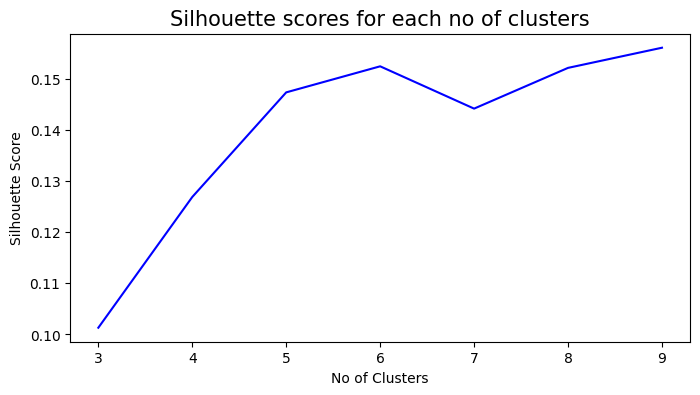

In [18]:
plt.figure(figsize= (8,4));
plt.plot( c,silhouette_scores,linestyle ='-',color = 'b');
plt.title('Silhouette scores for each no of clusters',fontsize=15);
plt.xlabel('No of Clusters');
plt.ylabel('Silhouette Score');

In [19]:
n_clusters = 6
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)

### 2.2 Analysing the Clusters <a id="4"></a>

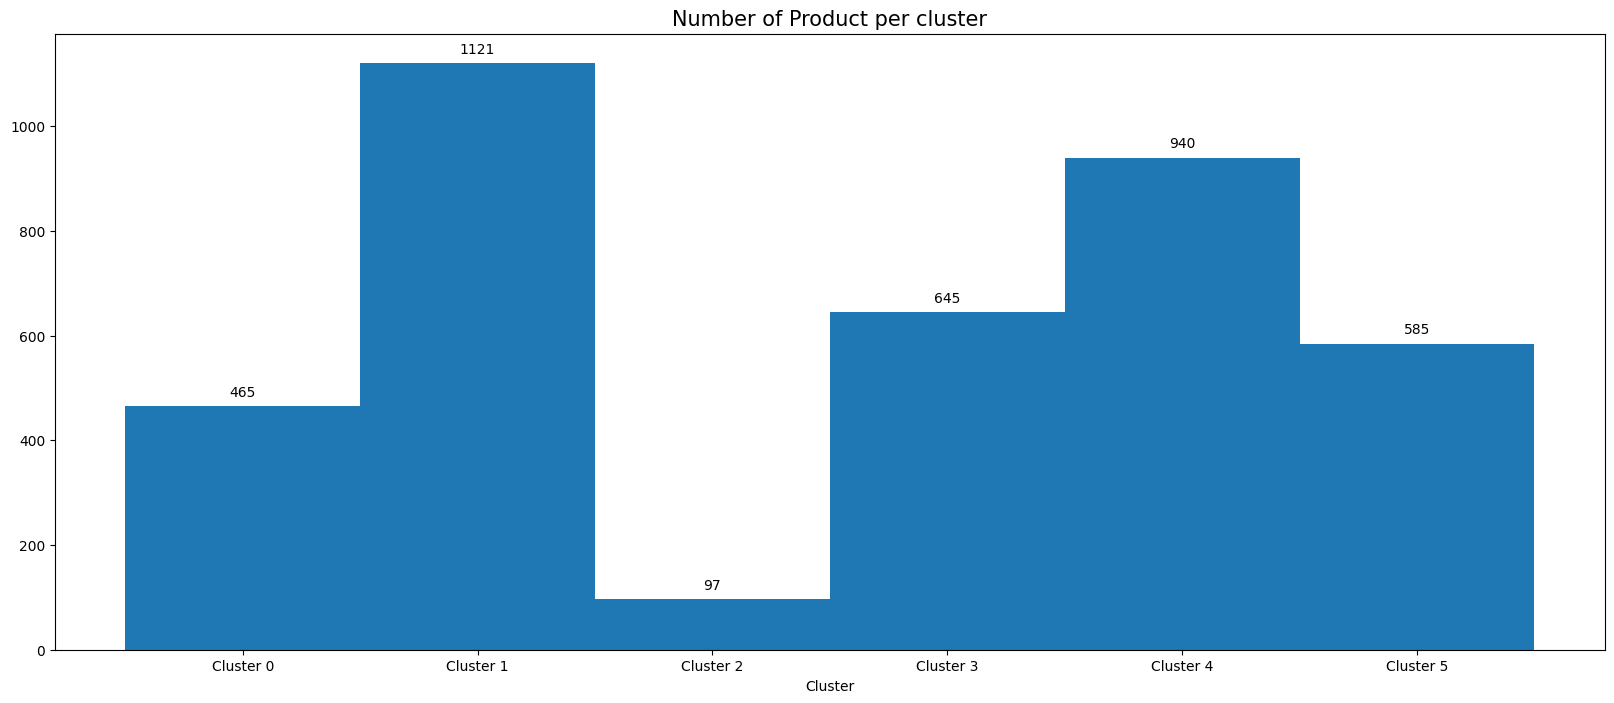

In [20]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=6) # arguments are passed to np.histogram
plt.xlabel("Cluster")
plt.title("Number of Product per cluster",fontsize=15)
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(6)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

plt.show()

### 2.3 Visualizing each cluster content <a id="5"></a>

In [21]:
product_list_df = pd.DataFrame(product_names)
words_list = [word for (word, occurence) in product_list]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    cluster = product_list_df.loc[clusters == i]
    for word in words_list:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: 
            continue
        occurence[i][word] = sum(cluster.loc[:, 0].str.contains(word.upper()))

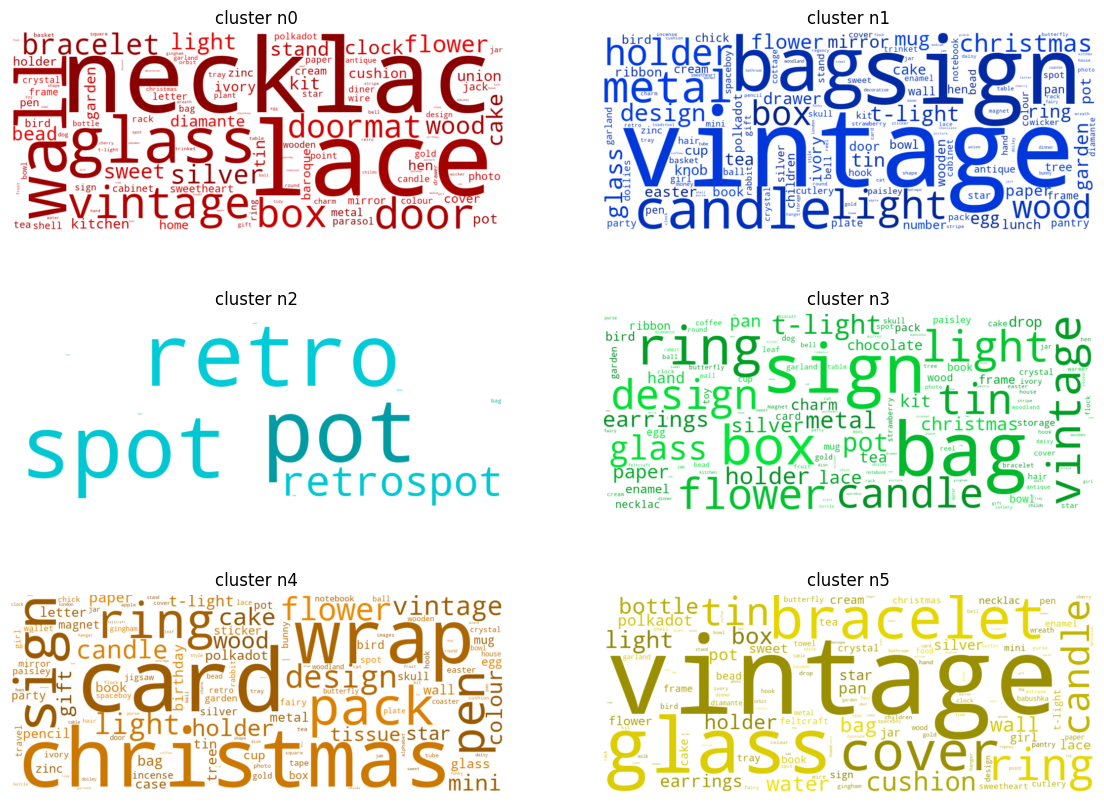

In [22]:

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    '''
    Utility function to choose random wordcloud color
    '''
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    '''
    Utility function to plot each cluster wordcloud
    '''
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    wordcloud = WordCloud(width=1000,height=400, background_color='white', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]

for i in range(n_clusters):
    list_cluster_occurences = occurence[i]
    tone = color[i] 
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

From the clusters we can see that one cluster is associated with christmas items i.e candles, cale,decoration etc. Another cluster is associated with luxuary items like necklace, silver, bracelet etc. Another cluster realted to vintage stuffs like retro, polkadot, retrospot. But it is observed that a few words occur in more than one cluster which make it tough to distinguish. In order to ensure these clusters are distinct Principal Component Analysis is performed.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


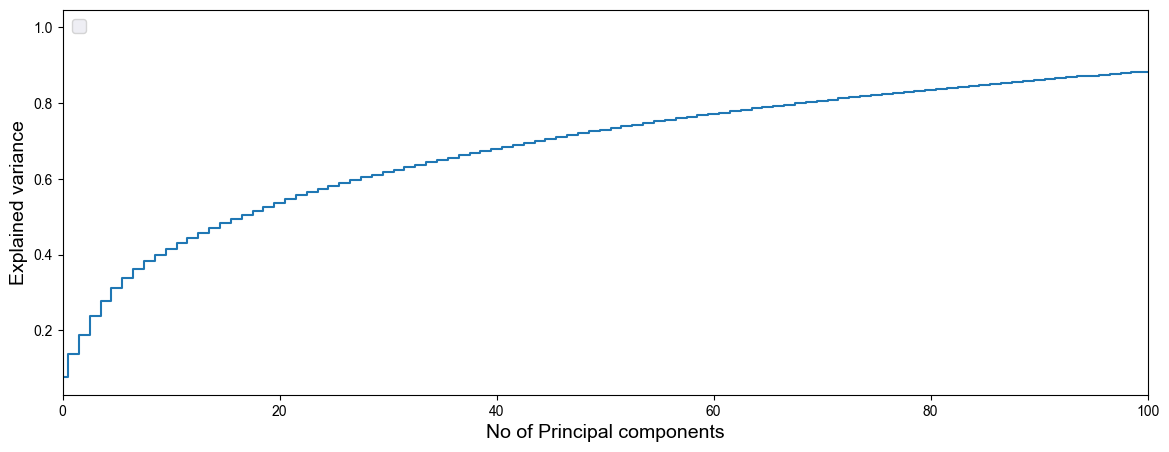

In [23]:
'''
Performing PCA and checking varience explained by each component
'''
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid')

plt.xlim(0, 100)

#ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('No of Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

Requires more than 100 components to explain 90% of the variance of the data

In [24]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

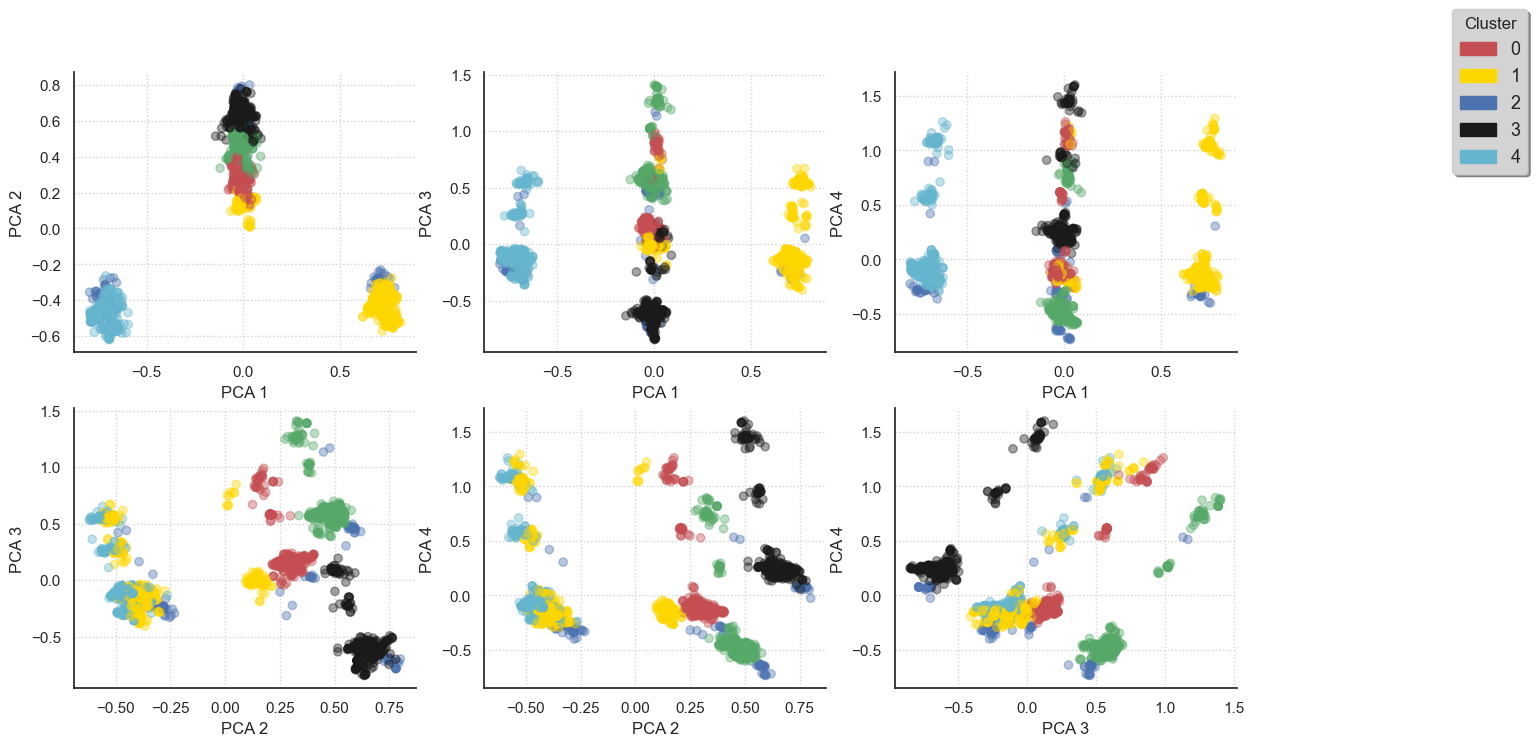

In [25]:


sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

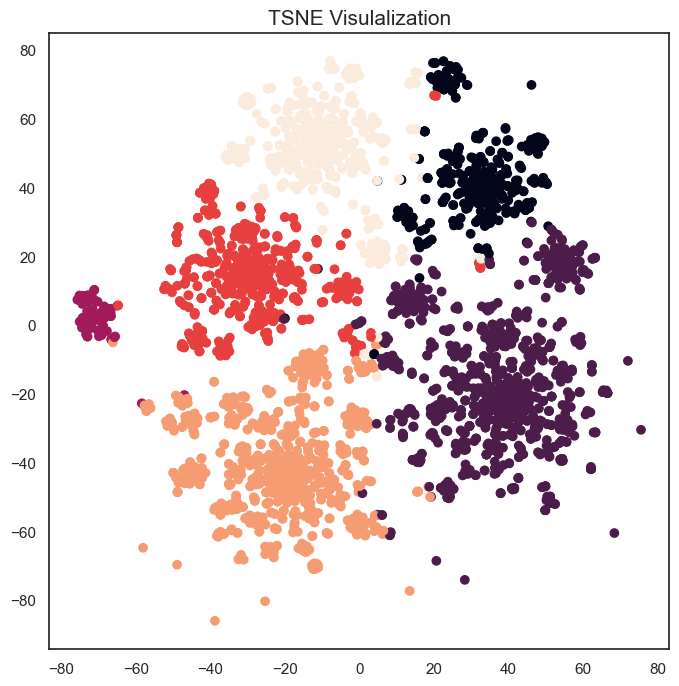

In [26]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X)

plt.figure(figsize=(8,8))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("TSNE Visulalization", fontsize="15")
plt.show()

In [27]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(product_names, clusters)}
cluster = df['Description'].apply(lambda x : dict_article_to_cluster[x])

### 2.4 Clustering customers <a id='6'></a>

In [30]:
'''
Data preparation for the customer clustering
'''
cluster = df['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Article_cluster").mul(df["TotalCost"], 0)
df2 = pd.concat([df['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

custom_aggregation = {}
custom_aggregation["TotalCost"] = "sum"
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"

df_grouped = df.groupby("InvoiceNo").agg(custom_aggregation)


now = df_grouped["InvoiceDate"].max() 
df_grouped["Recency"] = now - df_grouped["InvoiceDate"]
df_grouped["Recency"] = pd.to_timedelta(df_grouped["Recency"]).dt.days # conversion to day from now

df_grouped["nb_visit"] = 1
df_grouped["total_spent"] = 1

df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

custom_aggregation = {}
custom_aggregation["TotalCost"] = ["mean", "sum"]
custom_aggregation["nb_visit"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Recency"] = ["min", "max"]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)
df_grouped_final["Freq"] = (df_grouped_final["Recency"]["max"]  - df_grouped_final["Recency"]["min"] ) / df_grouped_final["nb_visit"]["sum"]
df_grouped_final.columns = ["avg_price", "sum_price", "nb_visit", "country", "quantity", "min_recency", "max_recency", "freq"]

X1 = df_grouped_final.values
X2 = df2_grouped_final.values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [31]:
kmeans = KMeans(init='k-means++', n_clusters = 6, n_init=30, random_state=25)  
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

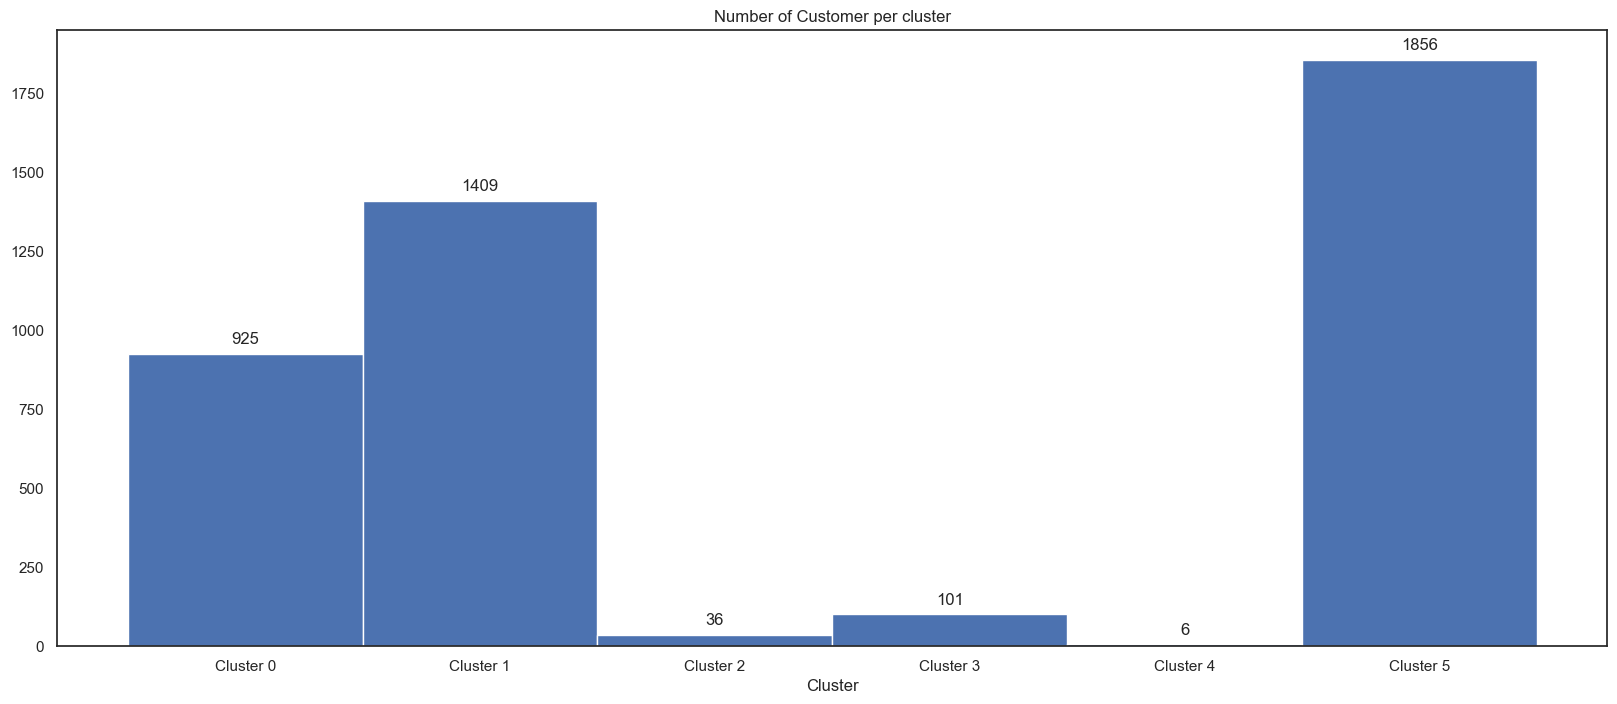

In [32]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=6) # arguments are passed to np.histogram
plt.xlabel("Cluster")
plt.title("Number of Customer per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(6)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

plt.show()

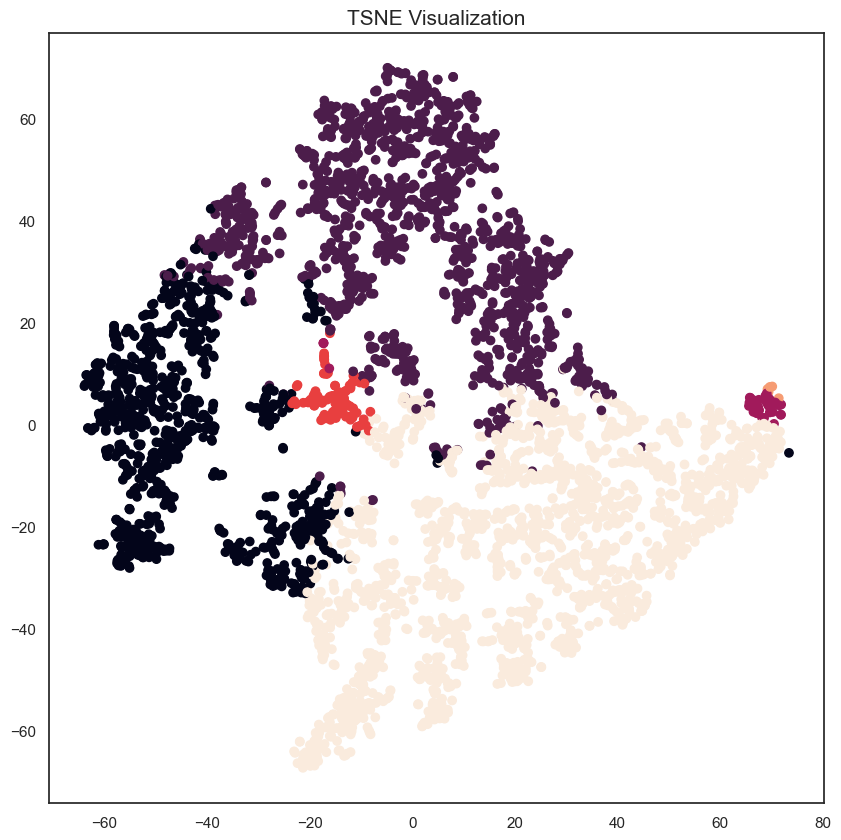

In [33]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("TSNE Visualization", fontsize="15")
plt.show()

In [34]:
df_grouped_final["cluster"] = clusters
df_grouped_final.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq,cluster
CustomerID,,,,,,,,,
12347,615.714286,4310.00,7,17.0,2458,1,366,52.142857,5
12348,359.310000,1437.24,4,12.0,2332,74,357,70.750000,5
12349,1457.550000,1457.55,1,11.0,630,18,18,0.000000,1
12350,294.400000,294.40,1,27.0,196,309,309,0.000000,3
12352,197.962857,1385.74,7,27.0,526,35,296,37.285714,3


In [35]:
df_analysis = df_grouped_final.groupby("cluster").mean()
df_analysis.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq
cluster,,,,,,,,
0,295.087323,447.227612,1.556757,10.190270,246.176216,257.812973,277.801081,7.300595
1,355.164972,673.686297,1.948900,10.246984,443.938964,49.445706,76.271824,8.637748
2,2128.193650,39226.228889,44.305556,10.611111,24529.111111,23.027778,342.416667,11.144696
3,1008.753734,2436.389505,2.663366,28.841584,1332.980198,107.267327,216.900990,29.822230
4,3574.186403,185895.701667,75.500000,24.833333,91219.666667,6.666667,361.166667,7.152145


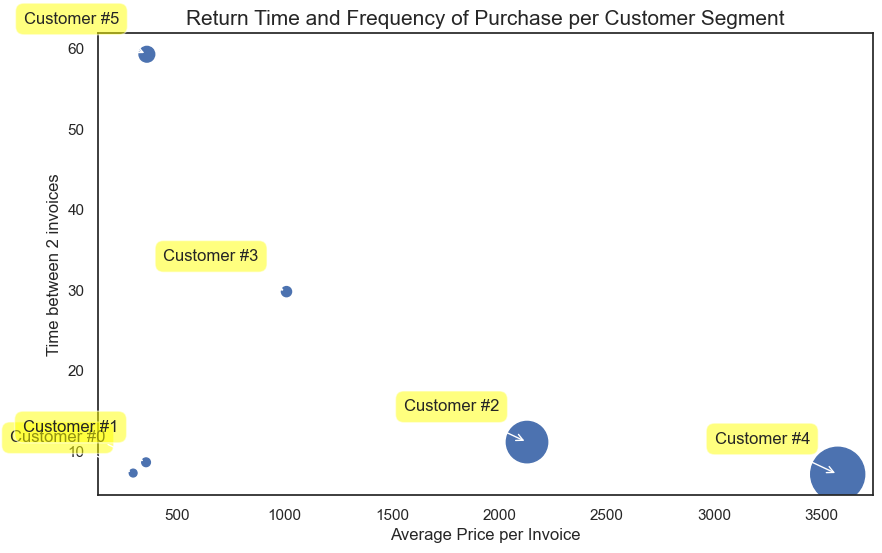

In [36]:
price = df_analysis["avg_price"].values
freq = df_analysis["freq"].values
visit = df_analysis["nb_visit"].values

plt.figure(figsize = (10,6))
plt.scatter(price, freq, s=visit*20)
    
for label, x, y in zip(["Customer #{}".format(x) for x in range(6)], price, freq):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
plt.title("Return Time and Frequency of Purchase per Customer Segment",fontsize=15)
plt.xlabel("Average Price per Invoice")
plt.ylabel("Time between 2 invoices")

plt.show()

# Customer Classification

In [38]:
classification_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
classification_dataset.head()

X = classification_dataset.drop("cluster", axis=1).values
y = classification_dataset["cluster"].values

In [39]:
def evaluation(acc,Y_prediction,Y_test):
    '''
    Utility function to compute evaluation measures
    '''
    accuracy.append(acc)
    precision.append(precision_score(Y_prediction, Y_test,average='micro'))
    recall.append(recall_score(Y_prediction, Y_test, average='micro'))
    f1.append(f1_score(Y_prediction, Y_test,average='micro'))
    
def printResult():
    '''
    Utility function to print the results in tabular format
    '''
    dict = {'Model': models, 'Accuracy': accuracy,'F1 score':f1}  
    
    df = pd.DataFrame(dict)
    return df

In [44]:
X_train, X_test, y_train, Y_test = train_test_split(X, y, test_size=0.25)

models= []
accuracy = []
precision = []
recall = []
f1 = []

models.append('Decision Tree')
clf1 = DecisionTreeClassifier(random_state=25)
clf1.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test) 
acc = round(clf1.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred1,Y_test)

models.append('Random Forest')
clf2 = RandomForestClassifier(n_estimators=100,random_state=25)
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
acc = round(clf2.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred2,Y_test)

models.append('SVM')
clf3 = SVC()
clf3.fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)
acc = round(clf3.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred3,Y_test)

models.append('Logistic Regression')
clf4 = LogisticRegression()
clf4.fit(X_train, y_train)
y_pred4 = clf4.predict(X_test)
acc = round(clf4.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred4,Y_test)

models.append('Naive Bayes')
clf5 = GaussianNB()
clf5.fit(X_train, y_train)
y_pred5 = clf5.predict(X_test)
acc = round(clf5.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred5,Y_test)

models.append('XG Boost')
clf6 =  XGBClassifier()
clf6.fit(X_train, y_train)
y_pred6 = clf6.predict(X_test)
acc = round(clf6.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred6,Y_test)

models.append('Ada Boost')
clf7 = AdaBoostClassifier()
clf7.fit(X_train, y_train)
y_pred7 = clf7.predict(X_test)
acc = round(clf7.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred7,Y_test)

models.append('Light GBM')
clf8 = lgb.LGBMClassifier(force_col_wise=True)
clf8.fit(X_train, y_train)
y_pred8 = clf8.predict(X_test)
acc = round(clf8.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred8,Y_test)

models.append('KNN')
clf9 = KNeighborsClassifier(n_neighbors = 3)
clf9.fit(X_train, y_train)
y_pred9 = clf9.predict(X_test)
acc = round(clf9.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred9,Y_test)

models.append('Perceptron')
clf10 = Perceptron()
clf10.fit(X_train, y_train)
y_pred10 = clf10.predict(X_test)
acc = round(clf10.score(X_test, Y_test) * 100, 2)
evaluation(acc,y_pred10,Y_test)



[LightGBM] [Info] Total Bins 3091
[LightGBM] [Info] Number of data points in the train set: 3249, number of used features: 14
[LightGBM] [Info] Start training from score -1.537883
[LightGBM] [Info] Start training from score -1.141051
[LightGBM] [Info] Start training from score -4.718807
[LightGBM] [Info] Start training from score -3.667262
[LightGBM] [Info] Start training from score -6.294343
[LightGBM] [Info] Start training from score -0.845453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [45]:
printResult()

,Model,Accuracy,F1 score
0,Decision Tree,98.52,0.985240
1,Random Forest,98.80,0.988007
2,SVM,74.35,0.743542
3,Logistic Regression,84.50,0.845018
4,Naive Bayes,95.11,0.951107
5,XG Boost,98.80,0.988007
6,Ada Boost,75.83,0.758303
7,Light GBM,98.89,0.988930
8,KNN,90.77,0.907749
9,Perceptron,75.28,0.752768


Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
tgr


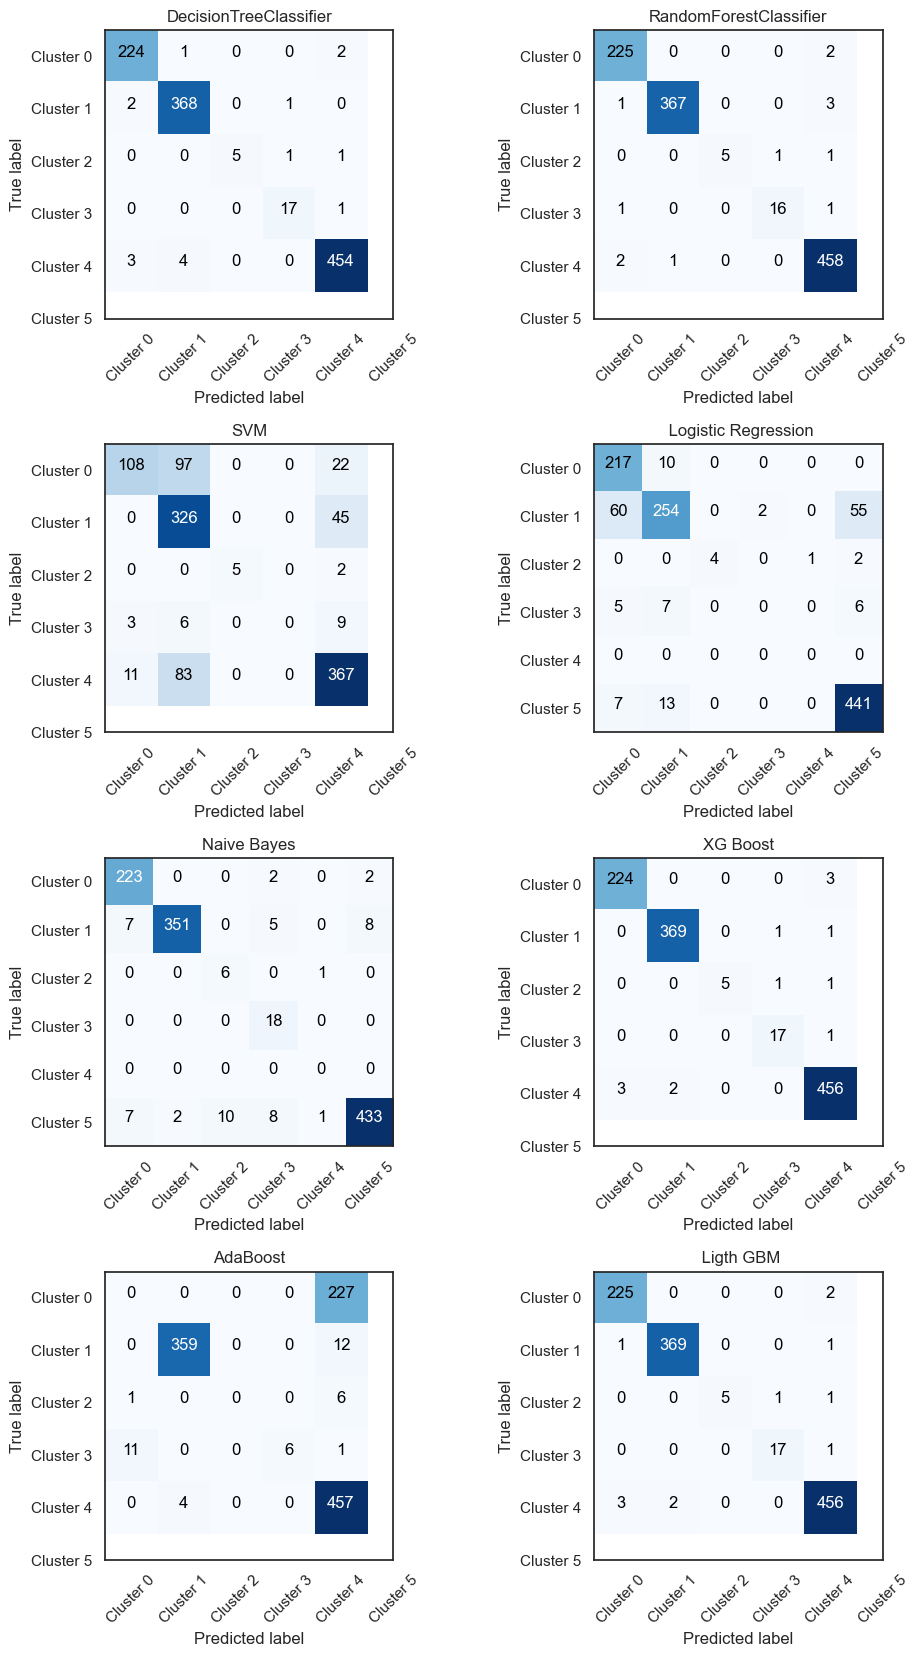

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

classes = ["Cluster {}".format(x) for x in range(6)]
np.set_printoptions(precision=2)

plt.figure(figsize=(10,20))
plt.subplot(5, 2, 1)
cnf_matrix = confusion_matrix(Y_test, y_pred1)
plot_confusion_matrix(cnf_matrix, classes=classes, title='DecisionTreeClassifier')

plt.subplot(5, 2, 2)
cnf_matrix = confusion_matrix(Y_test, y_pred2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='RandomForestClassifier')

plt.subplot(5, 2, 3)
cnf_matrix = confusion_matrix(Y_test, y_pred3)
plot_confusion_matrix(cnf_matrix, classes=classes, title='SVM')

plt.subplot(5, 2, 4)
cnf_matrix = confusion_matrix(Y_test, y_pred4)
plot_confusion_matrix(cnf_matrix, classes=classes, title=' Logistic Regression')

plt.subplot(5, 2, 5)
cnf_matrix = confusion_matrix(Y_test, y_pred5)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Naive Bayes')

plt.subplot(5, 2, 6)
cnf_matrix = confusion_matrix(Y_test, y_pred6)
plot_confusion_matrix(cnf_matrix, classes=classes, title='XG Boost')

plt.subplot(5, 2, 7)
cnf_matrix = confusion_matrix(Y_test, y_pred7)
plot_confusion_matrix(cnf_matrix, classes=classes, title='AdaBoost')

plt.subplot(5, 2, 8)
cnf_matrix = confusion_matrix(Y_test, y_pred8)
plot_confusion_matrix(cnf_matrix, classes=classes, title=' Ligth GBM')

#plt.subplot(5, 2, 9)
print('tgr')
cnf_matrix = confusion_matrix(Y_test, y_pred9)
#plot_confusion_matrix(cnf_matrix, classes=classes, title='KNN')

#plt.subplot(5, 2, 10)
cnf_matrix = confusion_matrix(Y_test, y_pred10)
#plot_confusion_matrix(cnf_matrix, classes=classes, title='Perceptron')
plt.show()



# RFM Analysis

RFM analysis is a data-driven customer behavior segmentation technique where RFM stands for recency, frequency, and monetary value. The idea is to segment customers based on when their last purchase was(Recency), how often they’ve purchased in the past(Frequency), and how much they spent(Monetary). All three of these measures have proven to be effective predictors of a customer’s willingness to engage in marketing messages and offers. <br>

**Reference:** [RFM Analysis in Python](https://medium.com/capillary-data-science/rfm-analysis-an-effective-customer-segmentation-technique-using-python-58804480d232)

In [47]:
import datetime as dt

today = dt.datetime(2012,1,1)
data_x = df.groupby('CustomerID').agg({'TotalCost': lambda x: x.sum(),
                                        'InvoiceDate': lambda x: (today - x.max()).days})
data_y = df.groupby(['CustomerID','InvoiceNo']).agg({'TotalCost': lambda x: x.sum()})

data_z = data_y.groupby('CustomerID').agg({'TotalCost': lambda x: len(x)})


In [48]:
'''
Create RFM Table
'''
rfm_table= pd.merge(data_x,data_z, on='CustomerID')
rfm_table.rename(columns= {'InvoiceDate': 'Recency',
                          'TotalCost_y': 'Frequency',
                          'TotalCost_x': 'Monetary'}, inplace= True)
rfm_table.head(5)

,Monetary,Recency,Frequency
CustomerID,,,
12347,4310.00,24,7
12348,1437.24,97,4
12349,1457.55,40,1
12350,294.40,332,1
12352,1385.74,58,7


In [49]:
#Frequency bulma
def FScore(x,p,d):
    if x <= d[p][0.20]:
        return 0
    elif x <= d[p][0.40]:
        return 1
    elif x <= d[p][0.60]: 
        return 2
    elif x <= d[p][0.80]:
        return 3
    else:
        return 4

quantiles = rfm_table.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
rfm_table['Freq_Tile'] = rfm_table['Frequency'].apply(FScore, args=('Frequency',quantiles,))
 
rfm_table = rfm_table.sort_values('Recency',ascending=True)
rfm_table['Rec_Tile'] = pd.qcut(rfm_table['Recency'],5,labels=False)

rfm_table['Mone_Tile'] = pd.qcut(rfm_table['Monetary'],5,labels=False)

rfm_table['Rec_Tile'] = rfm_table['Rec_Tile'] + 1
rfm_table['Freq_Tile'] = rfm_table['Freq_Tile'] + 1
rfm_table['Mone_Tile'] = rfm_table['Mone_Tile'] + 1

rfm_table['RFM Score'] = rfm_table['Rec_Tile'].map(str) + rfm_table['Freq_Tile'].map(str) + rfm_table['Mone_Tile'].map(str)
rfm_table.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
CustomerID,,,,,,,
16705,13985.39,22,20,5,1,5,155
17428,17256.85,22,28,5,1,5,155
18102,259657.30,22,60,5,1,5,155
12985,1239.38,22,2,2,1,4,124
17754,1739.50,22,5,4,1,4,144


In [50]:
rfm_table['RFM_Sum'] = rfm_table[['Freq_Tile','Rec_Tile','Mone_Tile']].sum(axis=1)
rfm_table.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum
CustomerID,,,,,,,,
16705,13985.39,22,20,5,1,5,155,11
17428,17256.85,22,28,5,1,5,155,11
18102,259657.30,22,60,5,1,5,155,11
12985,1239.38,22,2,2,1,4,124,7
17754,1739.50,22,5,4,1,4,144,9


In [51]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Sum'] >= 9:
        return 'Core'
    elif ((df['RFM_Sum'] >= 8) and (df['RFM_Sum'] < 9)):
        return 'Loyal'
    elif ((df['RFM_Sum'] >= 7) and (df['RFM_Sum'] < 8)):
        return 'Whales'
    elif ((df['RFM_Sum'] >= 6) and (df['RFM_Sum'] < 7)):
        return 'Rookies'
    elif ((df['RFM_Sum'] >= 5) and (df['RFM_Sum'] < 6)):
        return 'Slipping'
    else:
        return 'Regular'

rfm_table['RFM_Level'] = rfm_table.apply(rfm_level, axis=1)
rfm_table.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum,RFM_Level
CustomerID,,,,,,,,,
16705,13985.39,22,20,5,1,5,155,11,Core
17428,17256.85,22,28,5,1,5,155,11,Core
18102,259657.30,22,60,5,1,5,155,11,Core
12985,1239.38,22,2,2,1,4,124,7,Whales
17754,1739.50,22,5,4,1,4,144,9,Core


In [52]:
rfm_table["RFM_Level"].value_counts()

RFM_Level
Core        2200
Whales       704
Loyal        605
Rookies      399
Slipping     256
Regular      169
Name: count, dtype: int64

In [53]:
rfm_level_agg = rfm_table.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
print(rfm_level_agg)

          Recency Frequency Monetary      
             mean      mean     mean count
RFM_Level                                 
Core         94.6       6.9   3491.1  2200
Loyal       164.1       1.8    579.7   605
Regular      37.4       1.1    179.7   169
Rookies      89.9       1.4    320.9   399
Slipping     56.3       1.3    245.6   256
Whales      185.8       1.4    338.7   704


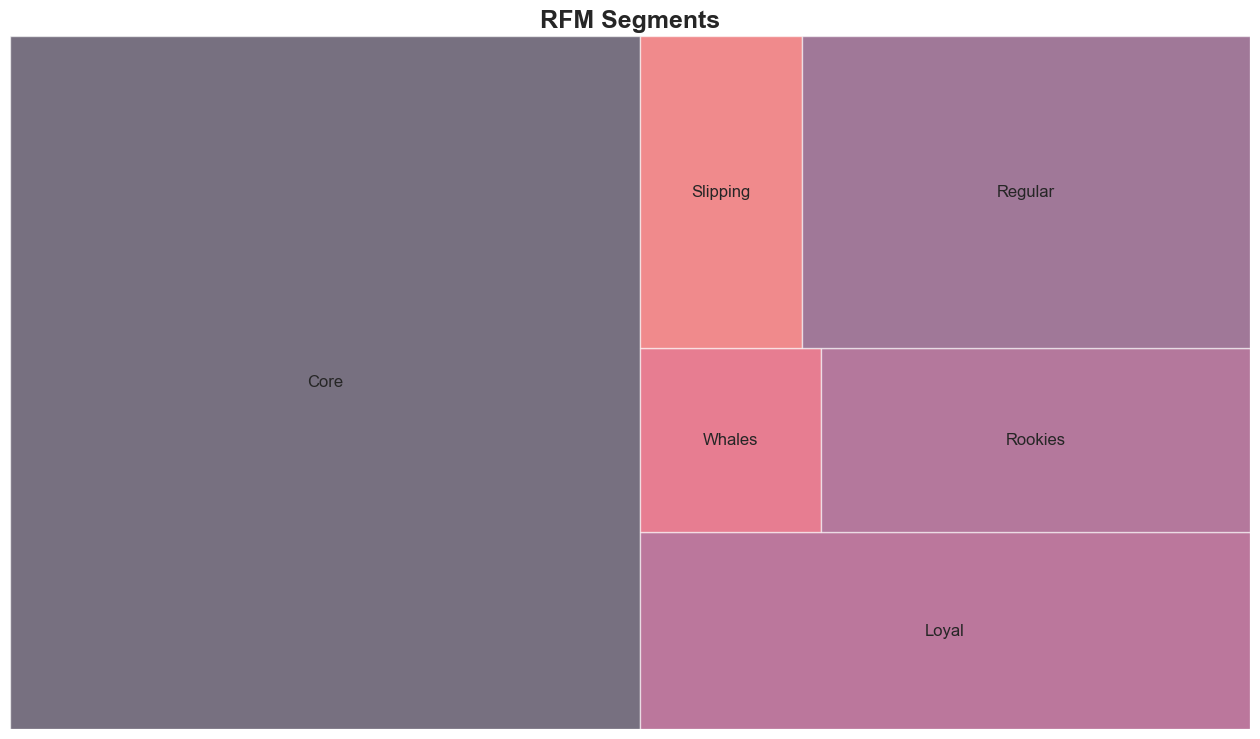

In [54]:

rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Core',
                     'Loyal',
                     'Whales',
                     'Rookies',
                     'Slipping', 
                     'Regular'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# Market Basket Analysis

In [55]:
#Converting data to binary format suitable for Apriori
data_apr = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
def num(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_new = data_apr.applymap(num)

In [56]:
items = apriori(basket_new, min_support=0.02, use_colnames=True)
rule = association_rules(items, metric="lift", min_threshold=1)

In [57]:
rule['consequents'] = rule['consequents'].apply(lambda x: list(x))
rule['antecedents'] = rule['antecedents'].apply(lambda x: list(x))